In [ ]:
!pip install pyarrow==0.16.0
!pip install pyscenic
!pip install arboreto

In [ ]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
!wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.mgi-m0.001-o0.0.tbl

--2022-05-10 03:06:23--  https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.mgi-m0.001-o0.0.tbl
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.65.132, 2a02:2c40:0:80::80:1284
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.65.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112121859 (107M)
Saving to: ‘motifs-v9-nr.mgi-m0.001-o0.0.tbl’

motifs-v9-nr.mgi-m0 100%[===================>] 106.93M  7.06MB/s    in 14s     

2022-05-10 03:06:37 (7.59 MB/s) - ‘motifs-v9-nr.mgi-m0.001-o0.0.tbl’ saved [112121859/112121859]



In [ ]:
BASEFOLDER_NAME = '/content/'

MOTIFS_HGNC_FNAME = os.path.join(BASEFOLDER_NAME, 'motifs-v9-nr.mgi-m0.001-o0.0.tbl')
OUT_TFS_HGNC_FNAME = os.path.join(BASEFOLDER_NAME, 'pySCENIC/resources/mm_mgi_tfs.txt')

In [ ]:
!pip install anndata
import anndata
adata_vil = anndata.read_h5ad("/content/drive/MyDrive/MI/scRNA_seq.h5ad")
adata_vil

     |████████████████████████████████| 96 kB 3.4 MB/s 


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 18862 × 27998
    obs: 'Stem_Cell_Property', 'Myocardial_infarction', 'Operation_time', 'Type'

In [ ]:
!pip install scanpy 

     |████████████████████████████████| 2.0 MB 14.6 MB/s 
     |████████████████████████████████| 11.2 MB 73.6 MB/s 
     |████████████████████████████████| 930 kB 53.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=e6840843108dfce5d37654e1ad66fb73766f97848ddbab890e5fe87cec20bd30
  Stored in directory: /root/.cache/pip/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import scanpy as sc
sc.pp.filter_cells(adata_vil, min_genes=200)
sc.pp.filter_genes(adata_vil, min_cells=3)
adata_vil.var['mt'] = adata_vil.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_vil, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_vil = adata_vil[adata_vil.obs.n_genes_by_counts < 8000, :]
adata_vil = adata_vil[adata_vil.obs.pct_counts_mt < 5, :]
adata_vil

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


View of AnnData object with n_obs × n_vars = 18408 × 22903
    obs: 'Stem_Cell_Property', 'Myocardial_infarction', 'Operation_time', 'Type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
from scipy.sparse import csr_matrix,csc_matrix

In [ ]:
gene_csc=csc_matrix(adata_vil.X)
gene_csc

<18408x22903 sparse matrix of type '<class 'numpy.float32'>'
	with 38205764 stored elements in Compressed Sparse Column format>

In [ ]:
!git clone https://github.com/aertslab/pySCENIC.git

Cloning into 'pySCENIC'...
remote: Enumerating objects: 3516, done.
remote: Counting objects: 100% (367/367), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 3516 (delta 196), reused 350 (delta 184), pack-reused 3149
Receiving objects: 100% (3516/3516), 31.85 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (2180/2180), done.


In [ ]:
adjacencies=pd.read_csv('/content/drive/MyDrive/MI/vil_adjacencies.tsv', sep='\t' , engine = 'python')
adjacencies

,TF,target,importance
0,Srbd1,Rgs5,3.552265e+02
1,Dgcr8,Rps4x,3.393613e+02
2,Dgcr8,Htr7,3.195776e+02
3,Myef2,Slc24a5,3.139293e+02
4,Rps4x,Irx3os,2.928546e+02
...,...,...,...
7323509,Zfp248,Prm1,1.532512e-22
7323510,Klf6,Gm28913,1.359900e-22
7323511,9130023H24Rik,A730032A03Rik,1.243688e-22
7323512,Zfy1,Il11,1.052136e-22


In [13]:
ex_matrix=pd.DataFrame(np.array(adata_vil.X.todense()),columns=adata_vil.var.index,index=adata_vil.obs.index)
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))
MODULES_FNAME = os.path.join(BASEFOLDER_NAME, "dec_modules.p")
with open(MODULES_FNAME, 'wb') as f:
    pickle.dump(modules, f)


2022-05-10 09:14:08,579 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-05-10 09:14:10,102 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-05-10 09:17:25,022 - pyscenic.utils - INFO - Creating modules.


In [20]:
!wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc9nr/gene_based/mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather

--2022-05-10 11:06:13--  https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc9nr/gene_based/mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.65.132, 2a02:2c40:0:80::80:1284
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.65.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1182754328 (1.1G)
Saving to: ‘mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather’

mm10__refseq-r80__1 100%[===================>]   1.10G  7.70MB/s    in 2m 32s  

2022-05-10 11:08:46 (7.41 MB/s) - ‘mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather’ saved [1182754328/1182754328]



In [21]:
!wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc9nr/gene_based/mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather

--2022-05-10 11:08:46--  https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc9nr/gene_based/mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.65.132, 2a02:2c40:0:80::80:1284
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.65.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1179716888 (1.1G)
Saving to: ‘mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather’

mm10__refseq-r80__5 100%[===================>]   1.10G  7.49MB/s    in 2m 21s  

2022-05-10 11:11:07 (8.01 MB/s) - ‘mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather’ saved [1179716888/1179716888]



In [24]:
DATABASES_GLOB = os.path.join(BASEFOLDER_NAME, "mm10__refseq-*.mc9nr.feather")
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="mm10__refseq-r80__10kb_up_and_down_tss.mc9nr"),
 FeatherRankingDatabase(name="mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr")]

In [25]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIFS_HGNC_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

# Save the enriched motifs and the discovered regulons to disk.
MOTIFS_FNAME = os.path.join(BASEFOLDER_NAME, "dec_motifs.csv")
df.to_csv(MOTIFS_FNAME)

REGULONS_FNAME = os.path.join(BASEFOLDER_NAME, "dec_regulons.p")
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 12.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


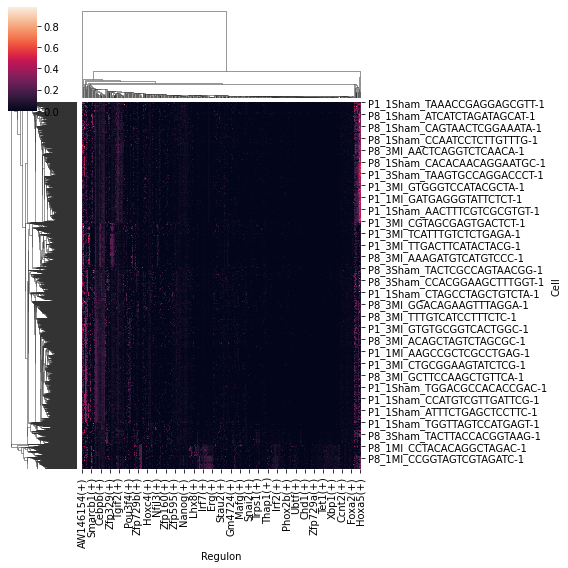

In [28]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)
auc_mtx.to_csv('dec_auc_mtx.tsv',sep='\t')
sns.clustermap(auc_mtx, figsize=(8,8))

In [29]:
reg={}
k=0
for i in regulons:
  reg[i.name]=i.gene2weight
  k+=1
  if k%100==0:
    print(k)

100
200
300
400


In [30]:
import networkx as nx
G = nx.Graph()
tf1=[]
for regulon in reg['ADARB1(+)']:
  #regulon=regulon.replace('.2','')
    tf1.append(regulon)
    for i in reg['ADARB1(+)'].keys():
        if reg['ADARB1(+)'][i]>1:
            G.add_edge('ADARB1(+)',i,weight=reg['ADARB1(+)'][i])

KeyError: ignored